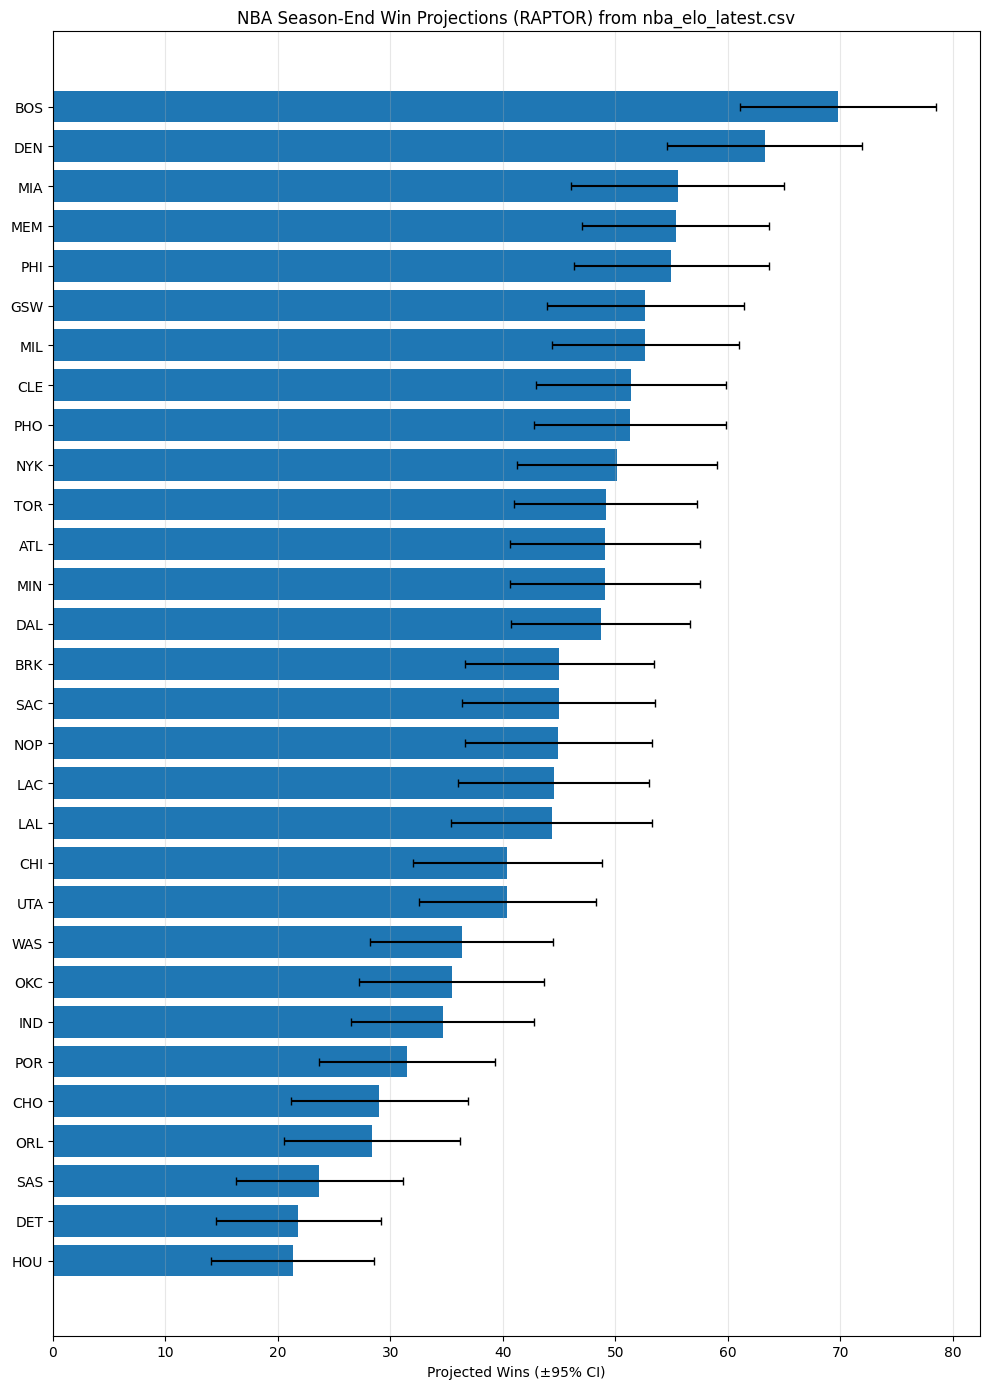

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the latest game‐by‐game predictions
df = pd.read_csv('nba_elo_latest.csv')

# 2. Build a long form table of (team, win_probability) for each game
#    Each row gives team1’s probability in raptor_prob1, and team2’s in raptor_prob2
team1 = df[['team1', 'raptor_prob1']].rename(columns={'team1':'team', 'raptor_prob1':'p'})
team2 = df[['team2', 'raptor_prob2']].rename(columns={'team2':'team', 'raptor_prob2':'p'})
probs = pd.concat([team1, team2], ignore_index=True)

# 3. For each team, compute:
#    • mean projected wins = sum of p’s
#    • variance      = sum of p*(1-p)
#    • SD            = sqrt(variance)
#    • 95% CI        ≈ mean ± 1.96*SD
stats = probs.groupby('team')['p'].agg([
    ('mean_wins', 'sum'),
    ('var_wins',   lambda x: np.sum(x*(1-x)))
]).reset_index()
stats['sd_wins'] = np.sqrt(stats['var_wins'])
stats['ci_lower'] = stats['mean_wins'] - 1.96*stats['sd_wins']
stats['ci_upper'] = stats['mean_wins'] + 1.96*stats['sd_wins']

# 4. Sort by mean projected wins for plotting
stats = stats.sort_values('mean_wins', ascending=False)

# 5. Plot a bar‐chart with error bars
plt.figure(figsize=(10, 14))
plt.barh(
    stats['team'],
    stats['mean_wins'],
    xerr=1.96*stats['sd_wins'],
    capsize=3
)
plt.gca().invert_yaxis()
plt.xlabel('Projected Wins (±95% CI)')
plt.title('NBA Season‐End Win Projections (RAPTOR) from nba_elo_latest.csv')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


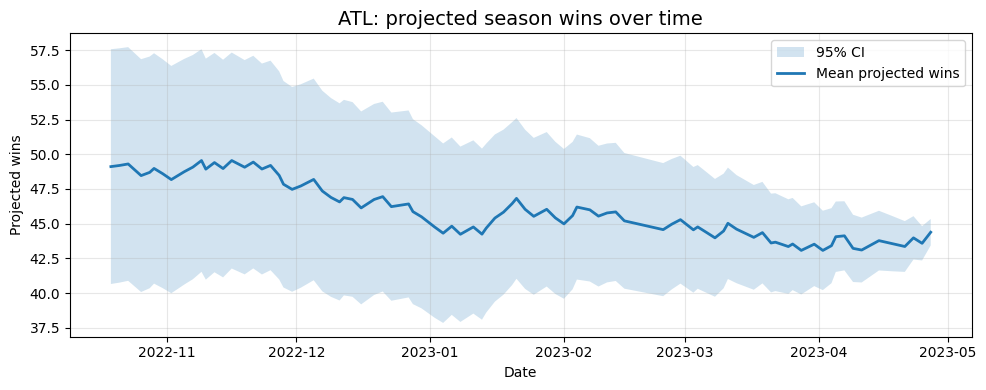

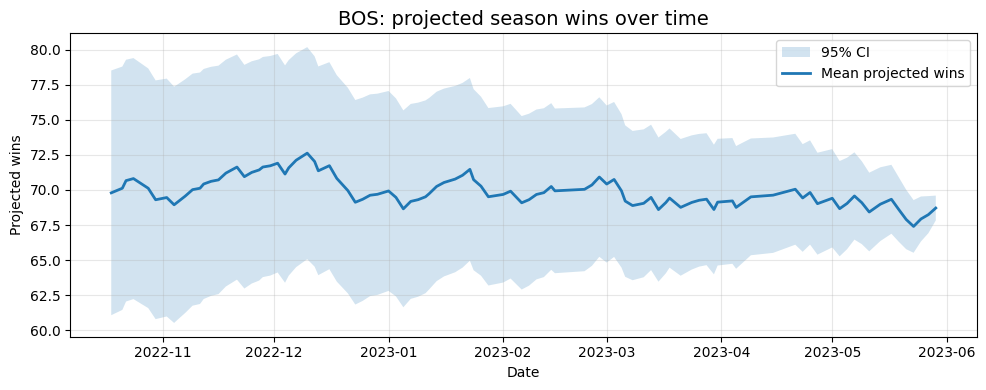

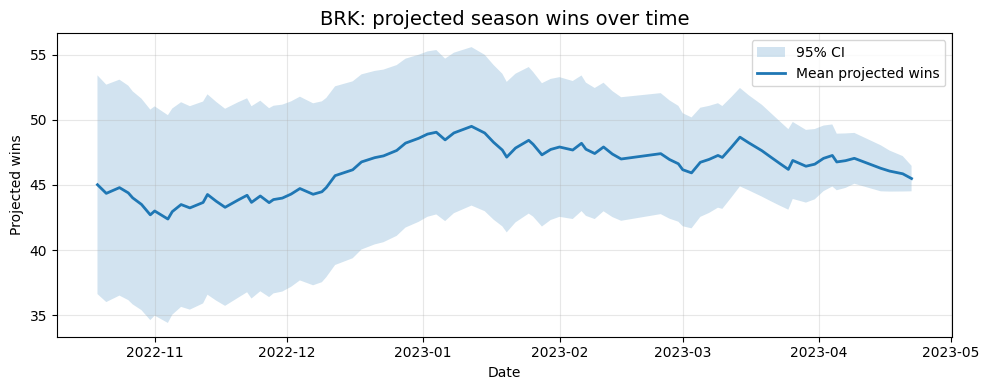

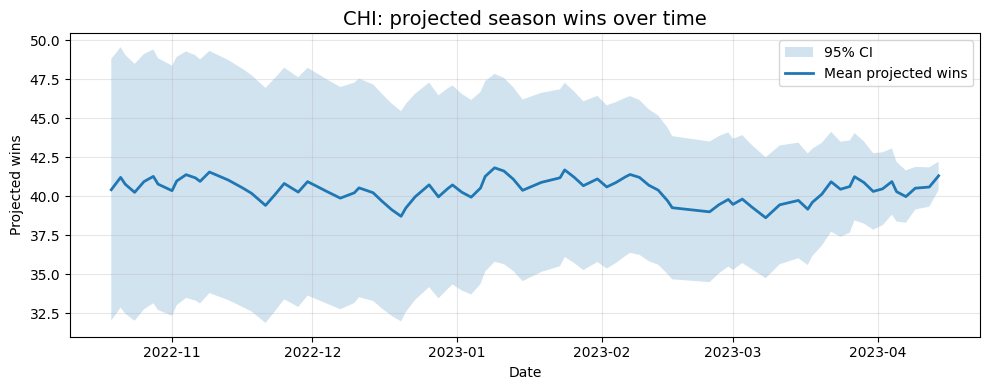

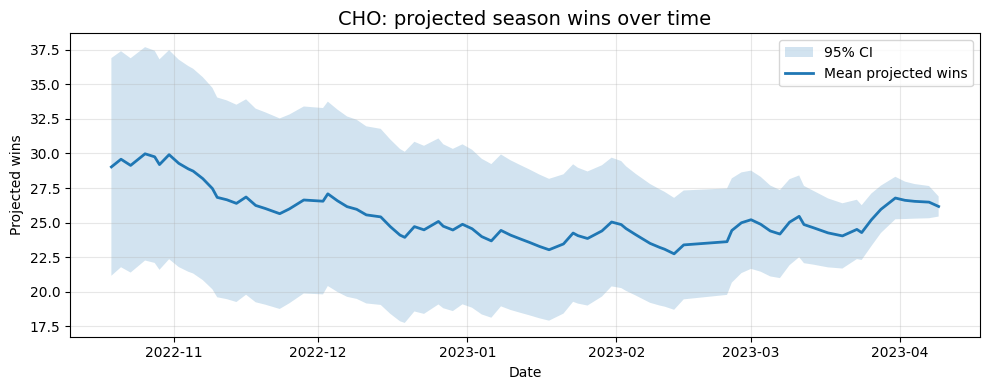

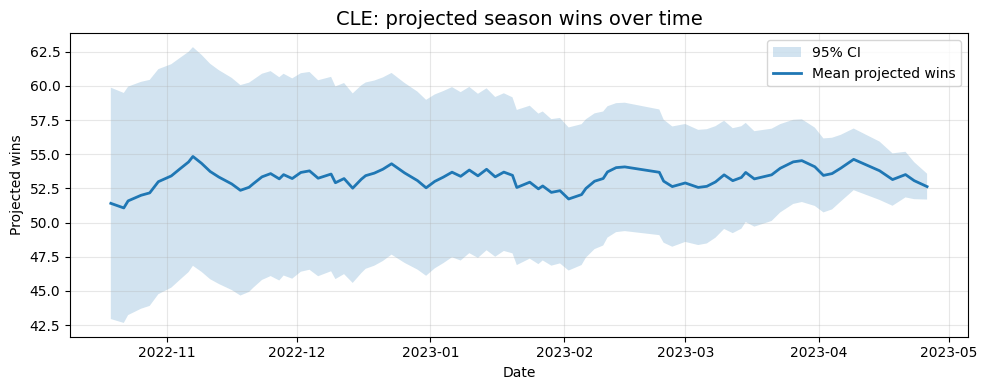

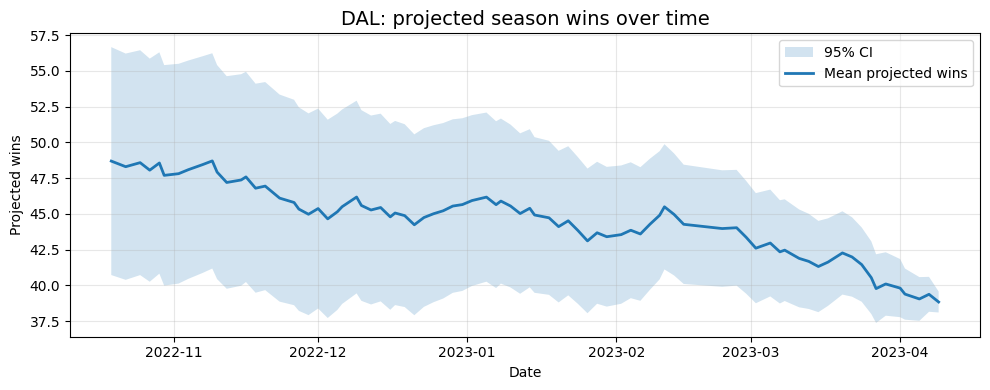

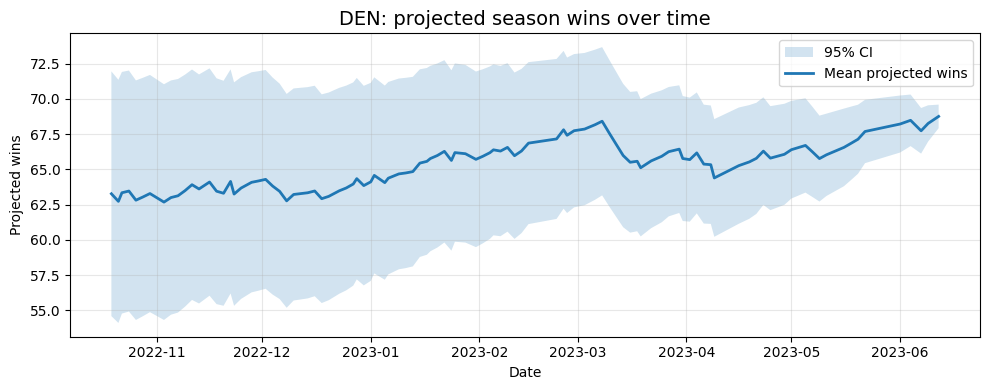

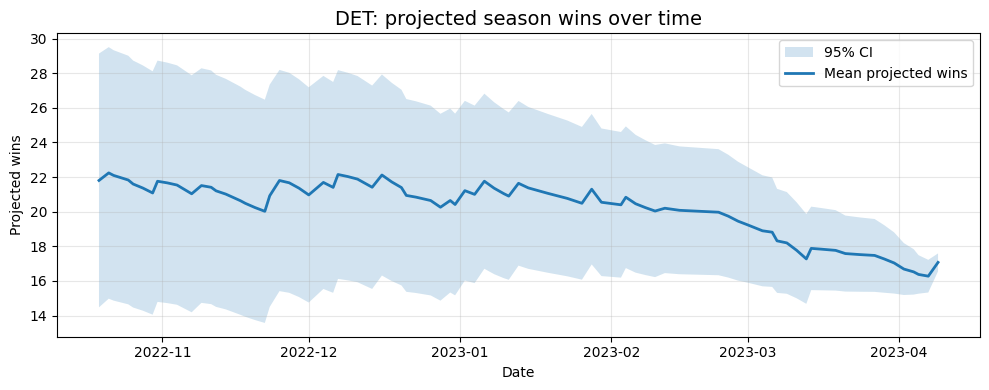

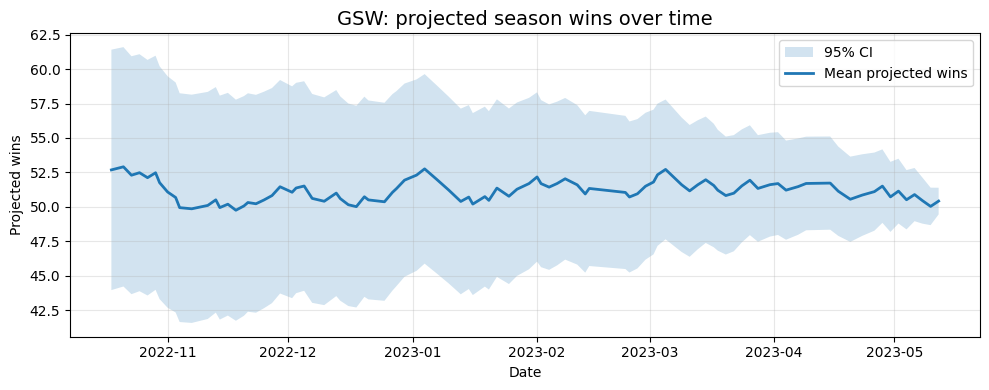

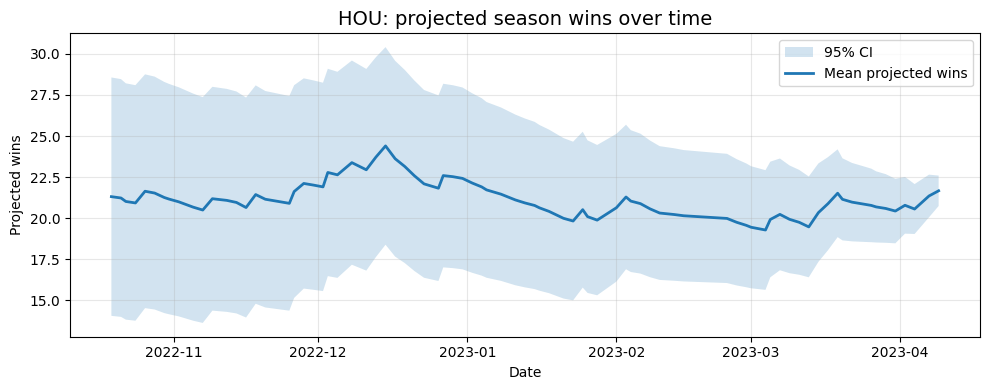

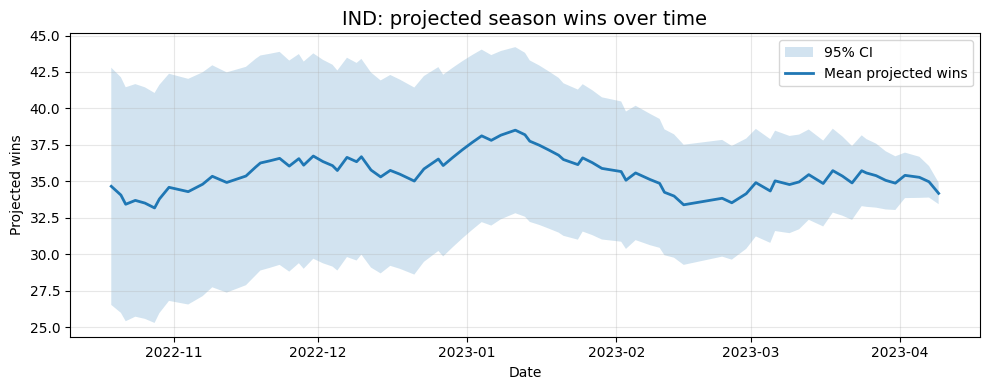

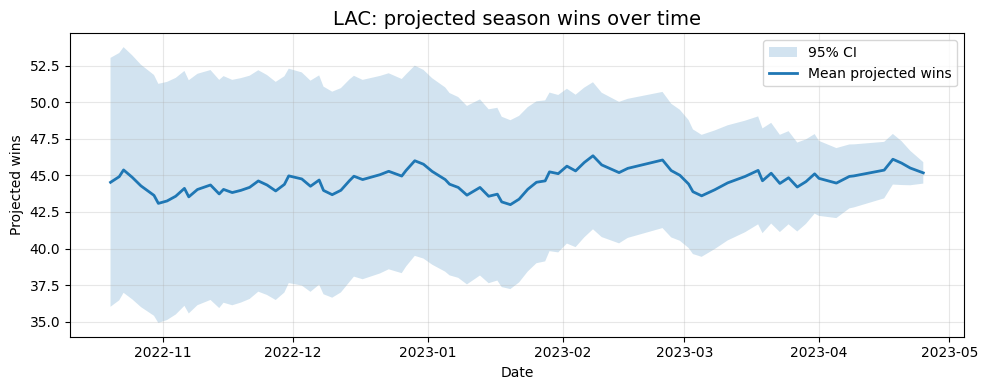

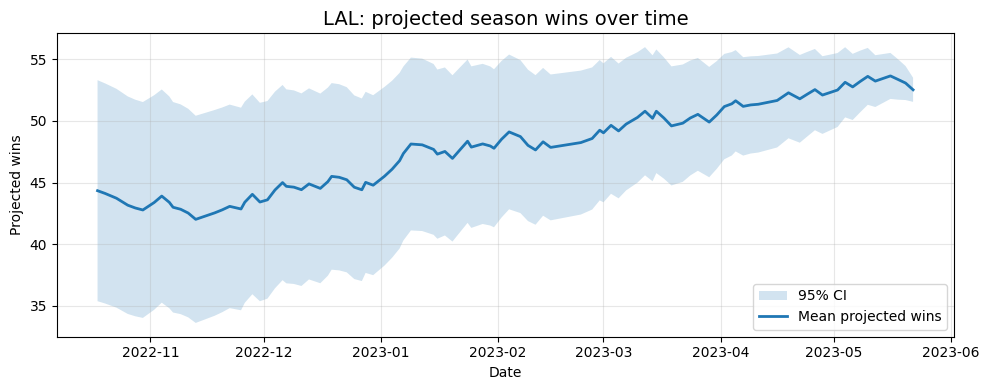

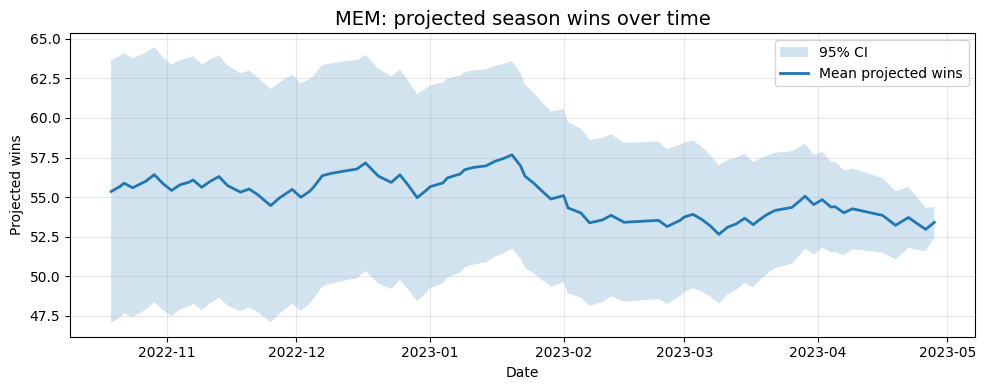

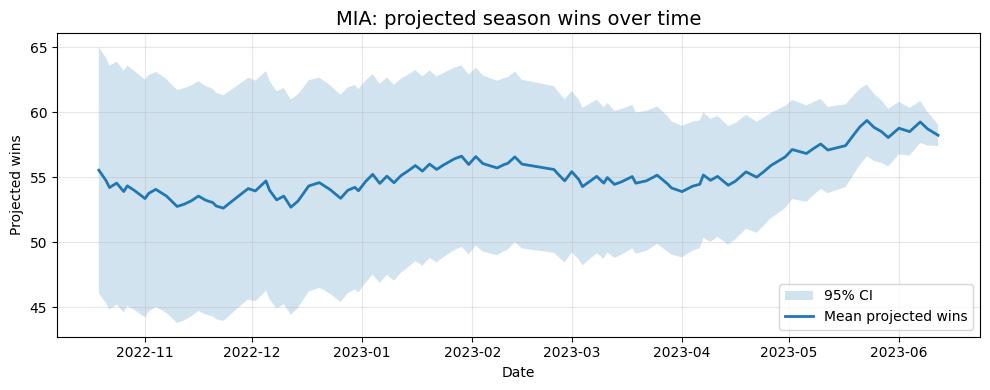

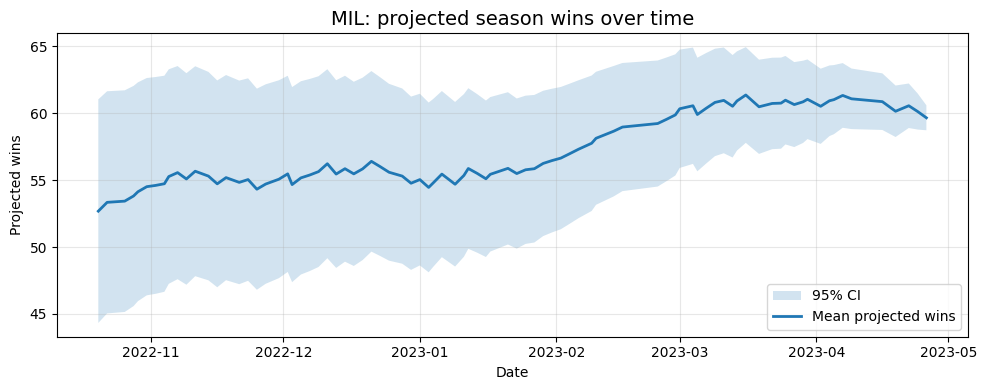

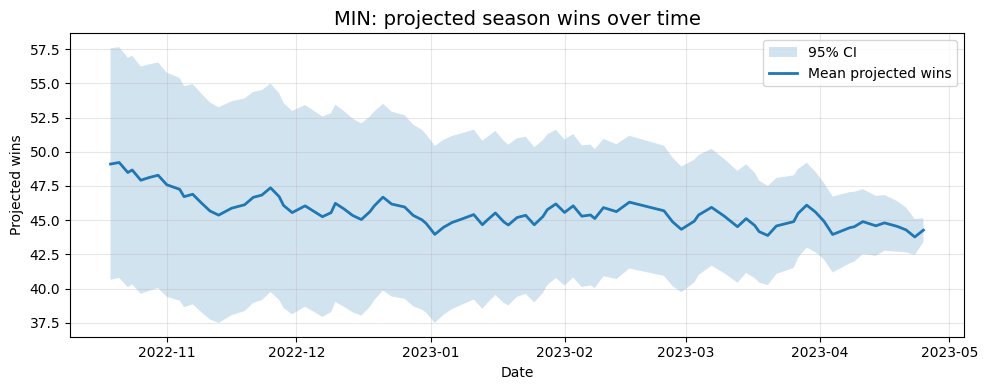

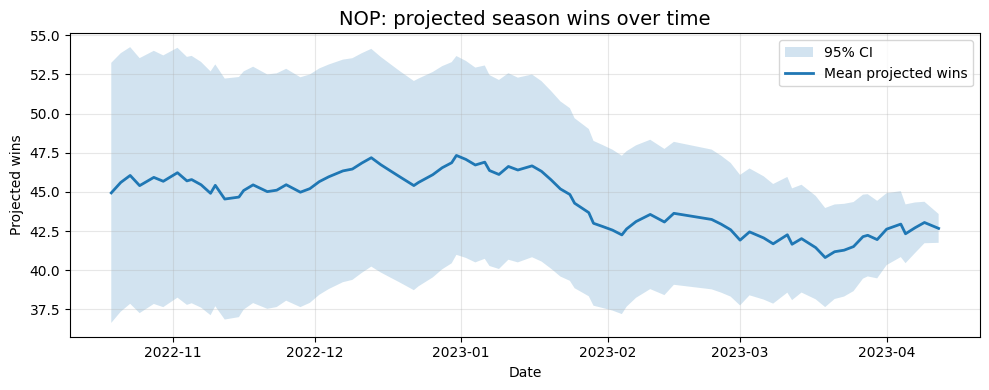

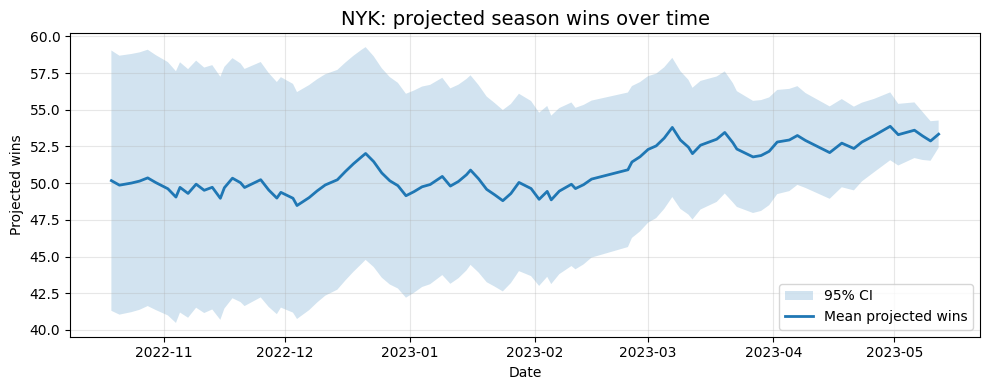

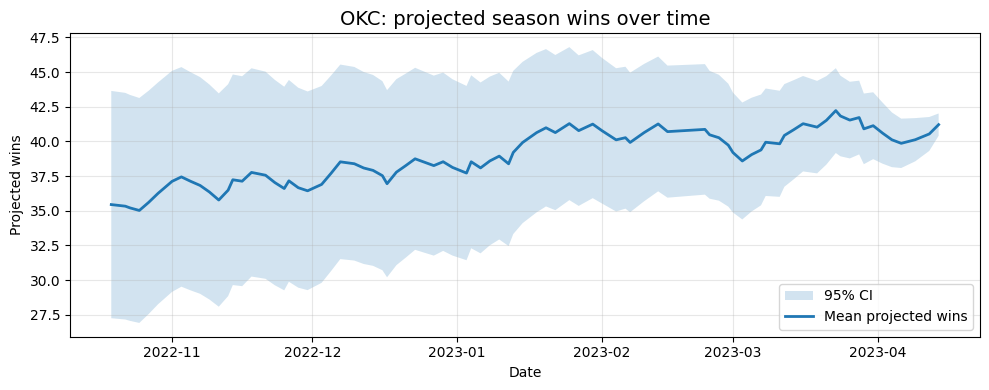

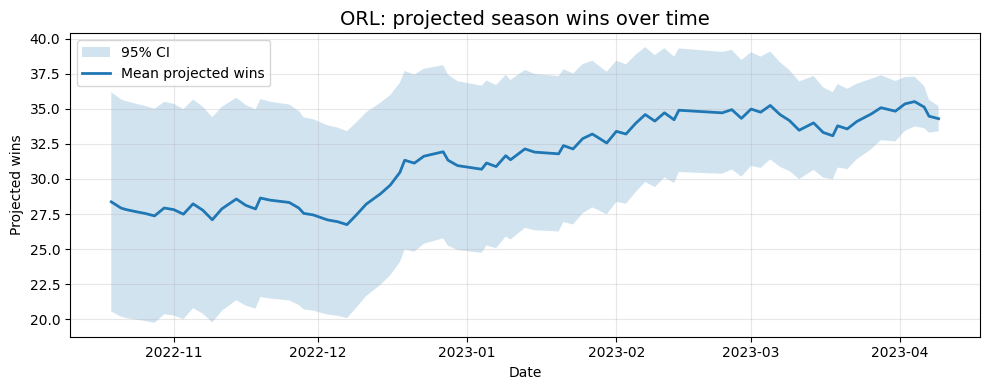

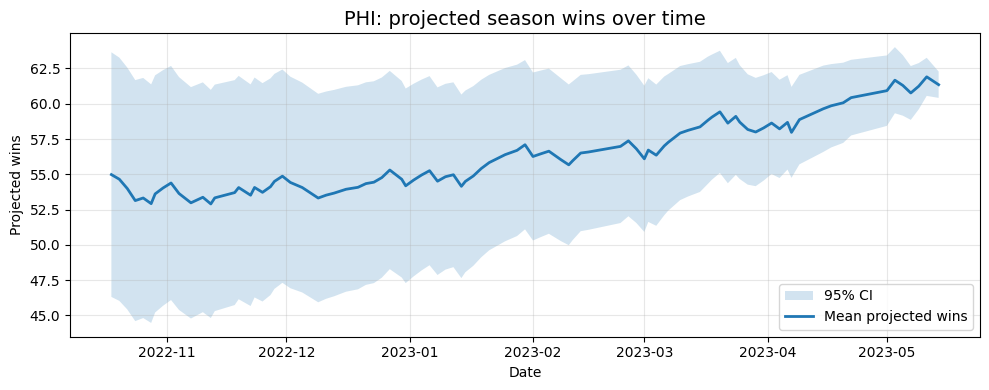

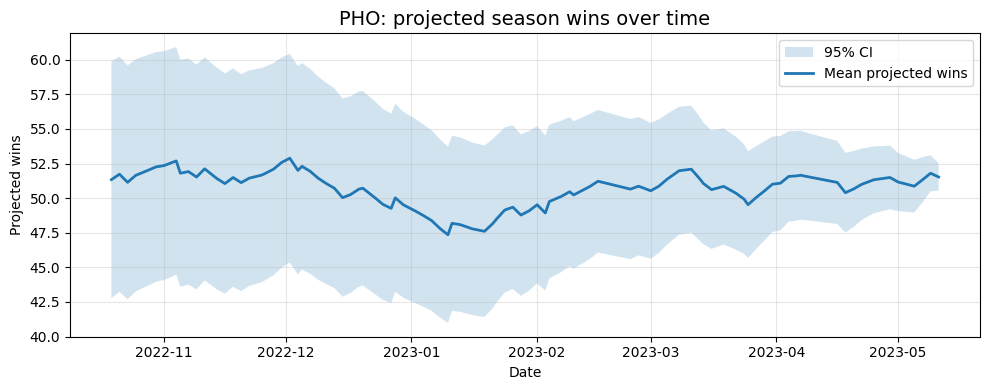

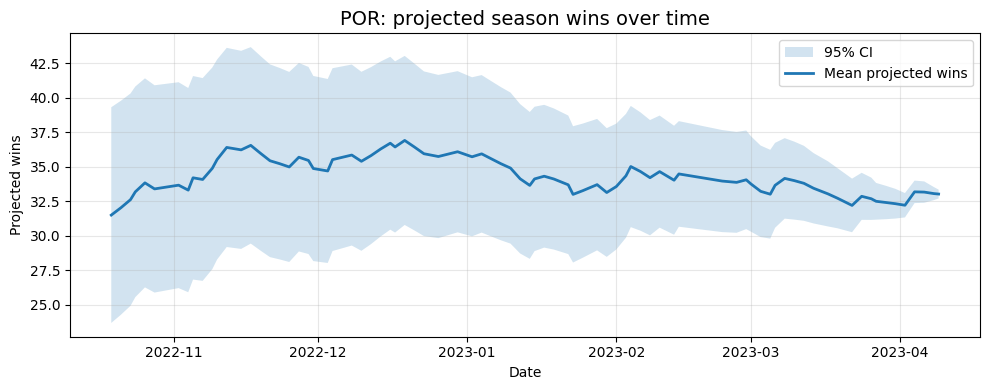

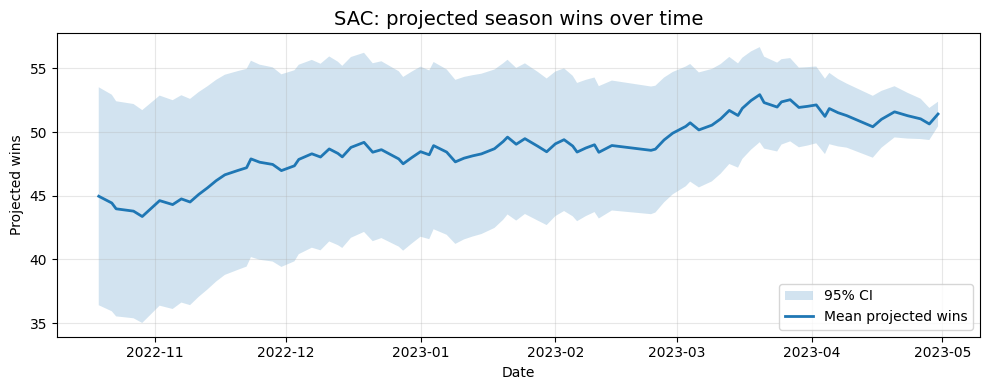

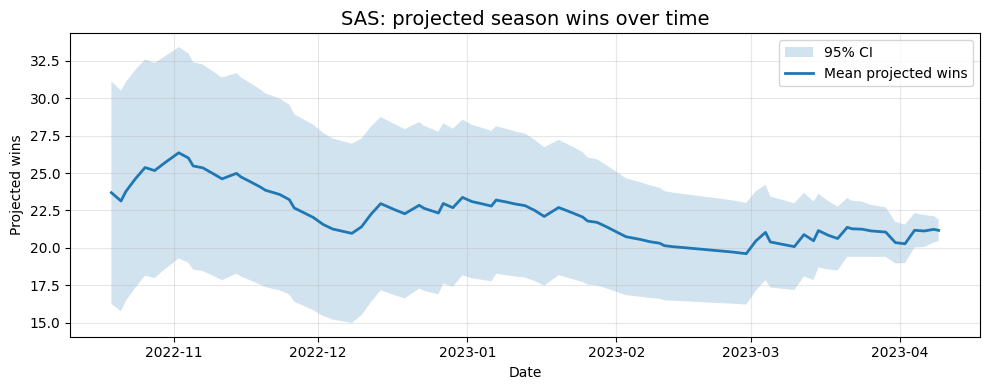

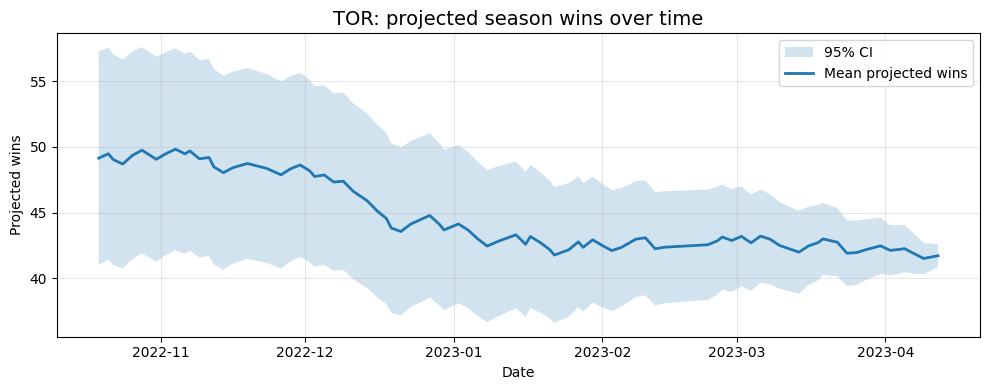

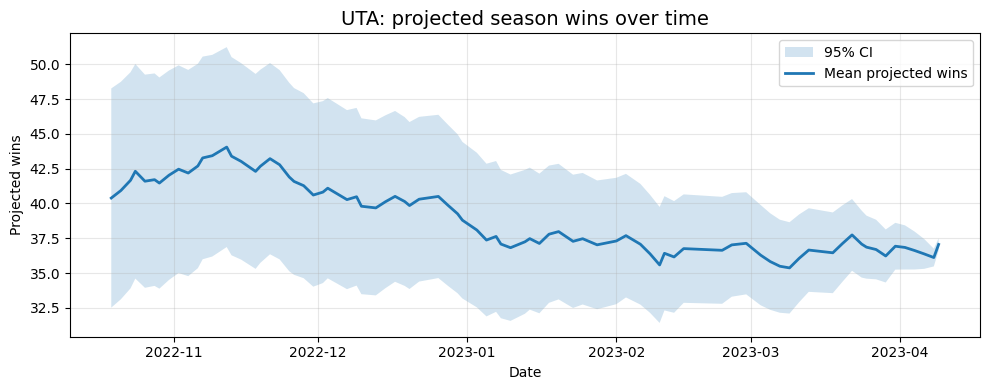

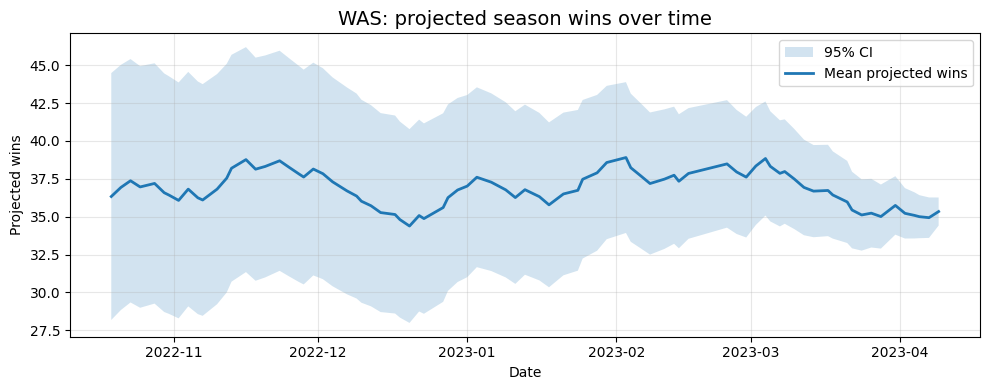

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the game-by-game RAPTOR predictions
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])

# 2. Flatten into one row per (team, game)
records = []
for _, row in df.iterrows():
    # team1
    records.append({
        'team':   row['team1'],
        'date':   row['date'],
        'prob':   row['raptor_prob1'],
        'actual': int(row['score1'] > row['score2'])
    })
    # team2
    records.append({
        'team':   row['team2'],
        'date':   row['date'],
        'prob':   row['raptor_prob2'],
        'actual': int(row['score2'] > row['score1'])
    })

flat = pd.DataFrame(records)

# 3. Function to build a timeseries of projected wins for a given team
def build_ts(team):
    g = flat[flat['team']==team].sort_values('date')
    dates = g['date'].unique()
    rows = []
    for d in dates:
        past   = g[g['date'] < d]
        future = g[g['date'] >= d]
        actual_wins = past['actual'].sum()
        exp_wins    = future['prob'].sum()
        var_future  = (future['prob'] * (1 - future['prob'])).sum()
        sd_future   = np.sqrt(var_future)
        mean_total  = actual_wins + exp_wins
        rows.append({
            'date':  d,
            'mean':  mean_total,
            'lower': mean_total - 1.96*sd_future,
            'upper': mean_total + 1.96*sd_future
        })
    return pd.DataFrame(rows)

# 4. Plot one chart per team
teams = sorted(flat['team'].unique())
for team in teams:
    ts = build_ts(team)
    plt.figure(figsize=(10,4))
    plt.fill_between(ts['date'], ts['lower'], ts['upper'], alpha=0.2,
                     label='95% CI')
    plt.plot(ts['date'], ts['mean'], lw=2, label='Mean projected wins')
    plt.title(f'{team}: projected season wins over time', fontsize=14)
    plt.xlabel('Date'); plt.ylabel('Projected wins')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()


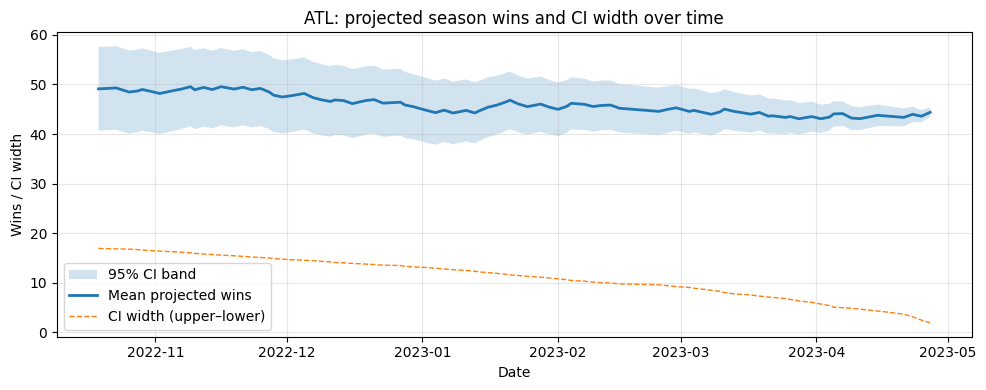

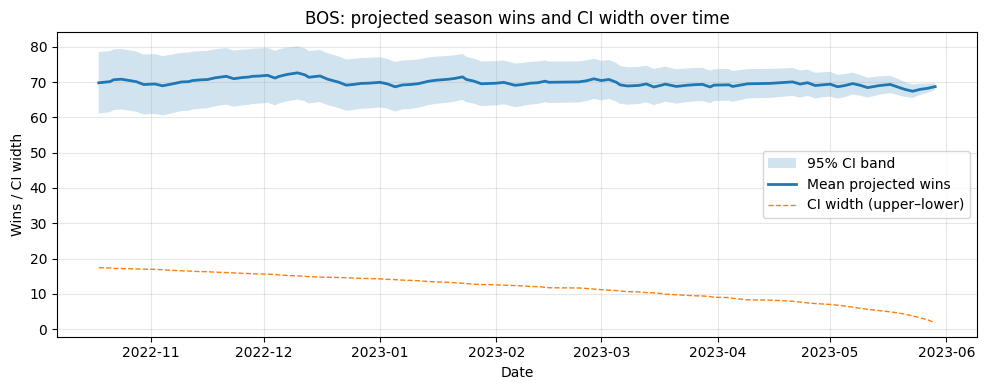

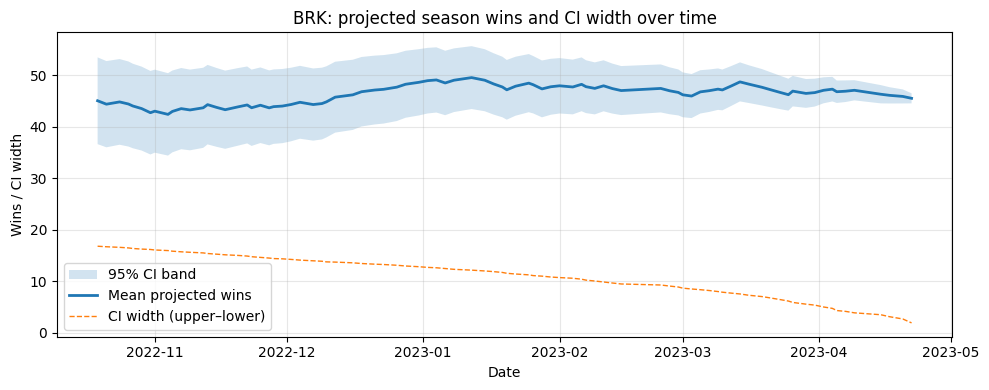

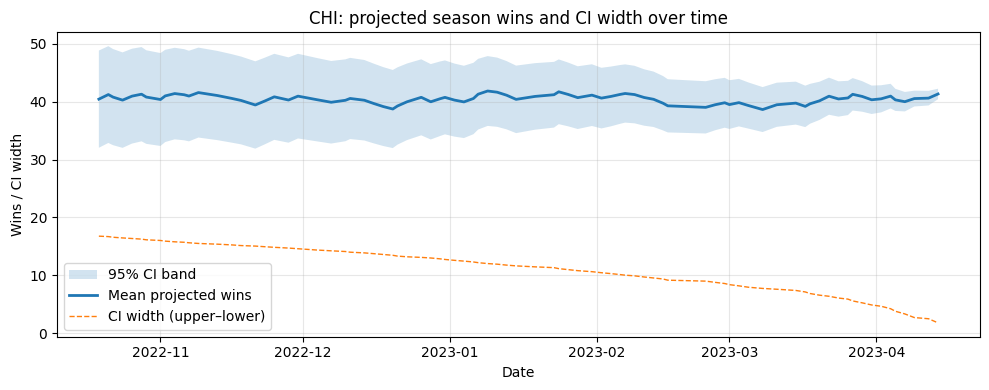

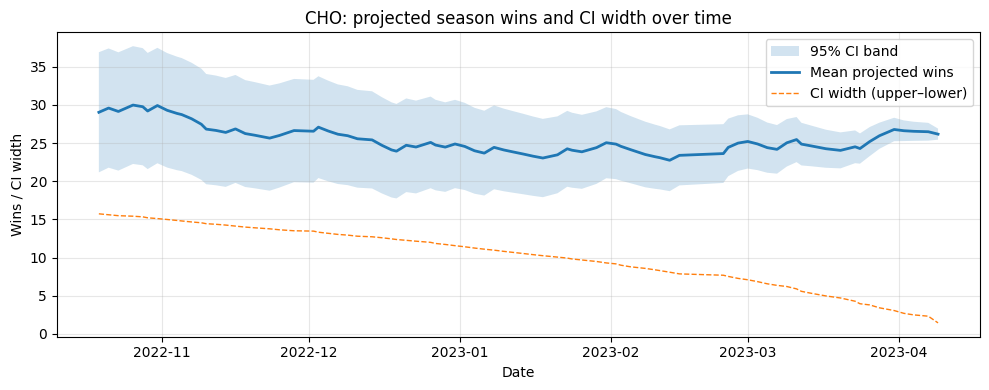

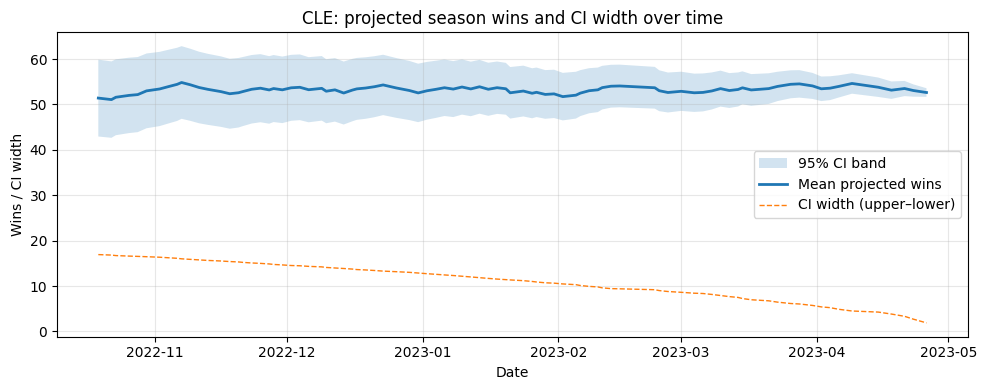

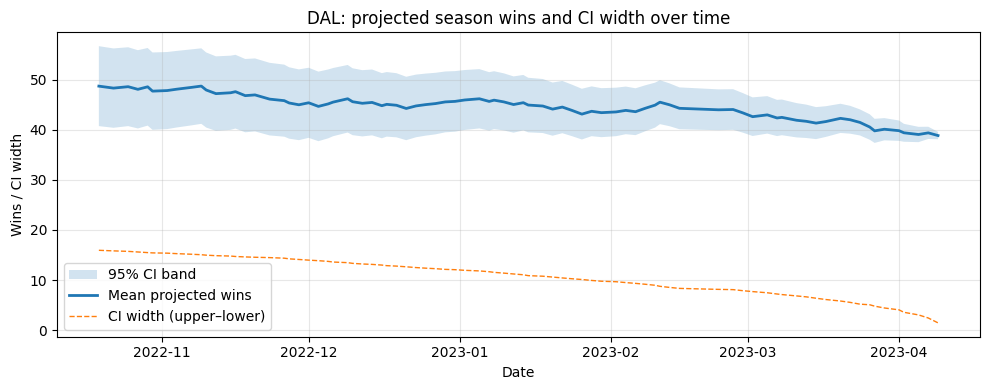

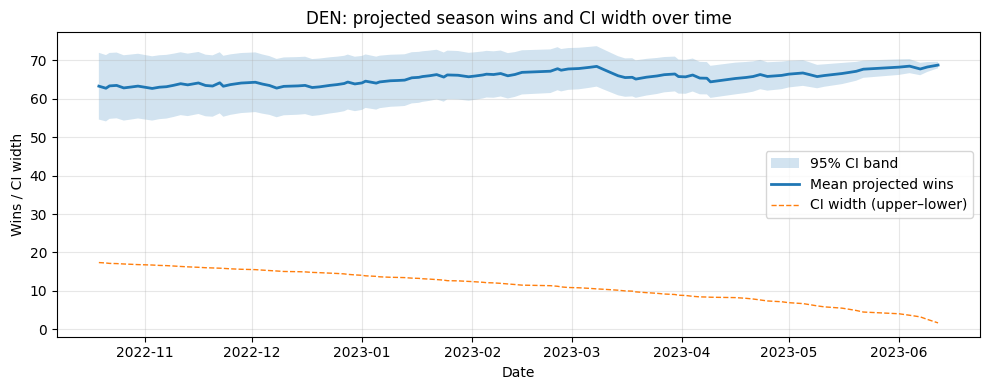

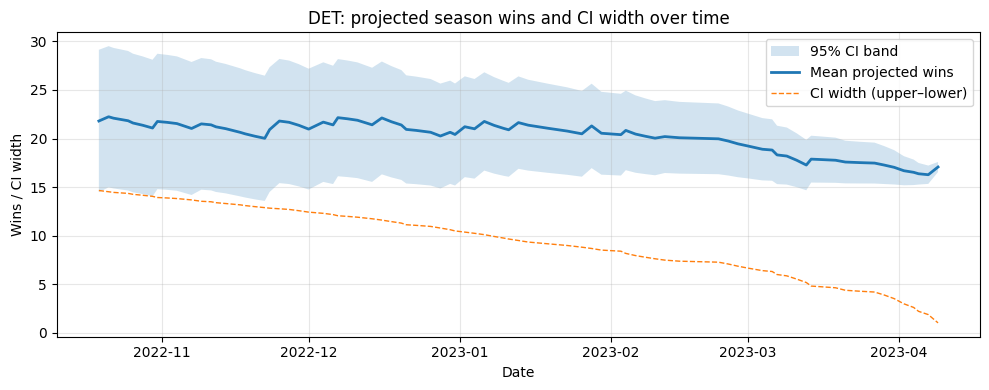

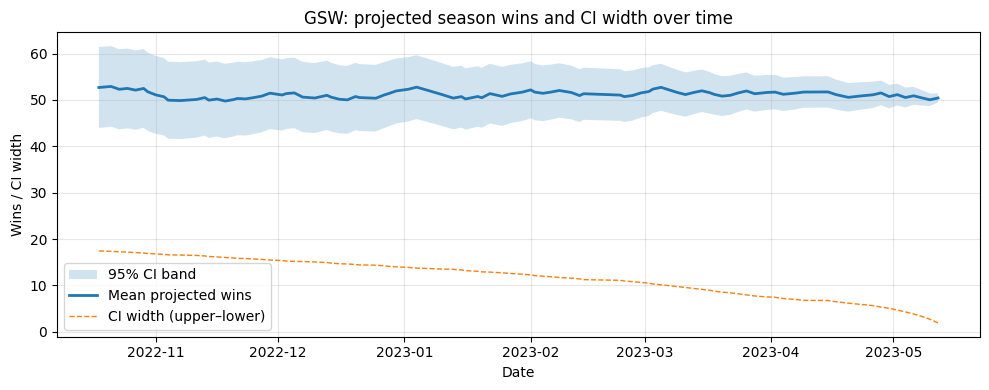

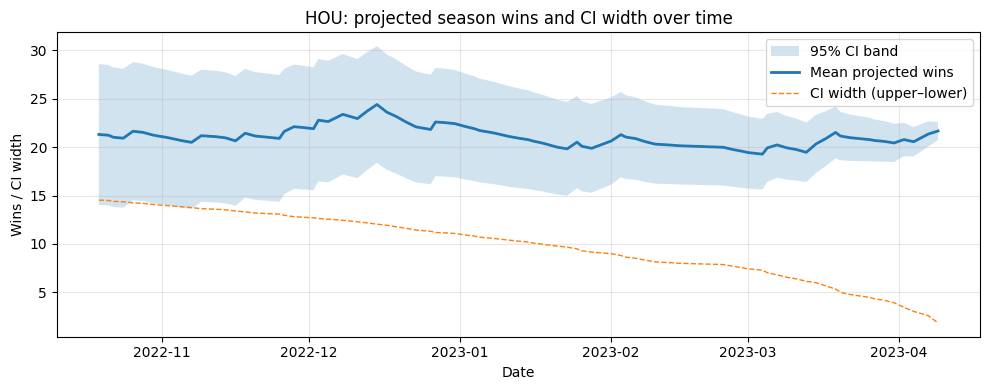

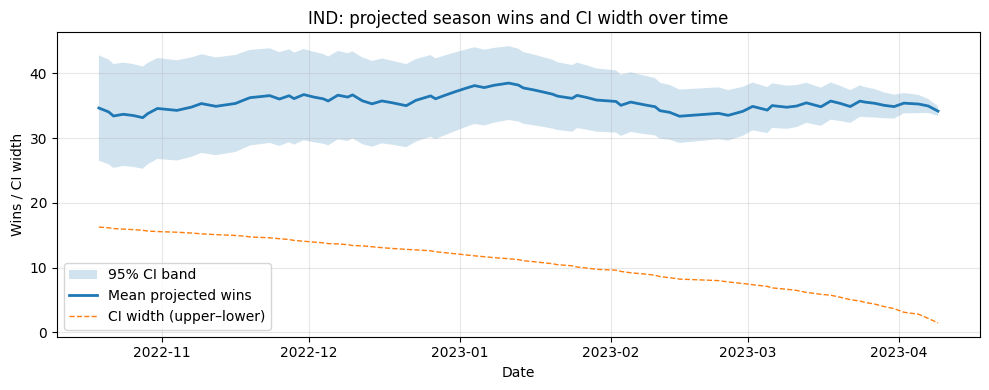

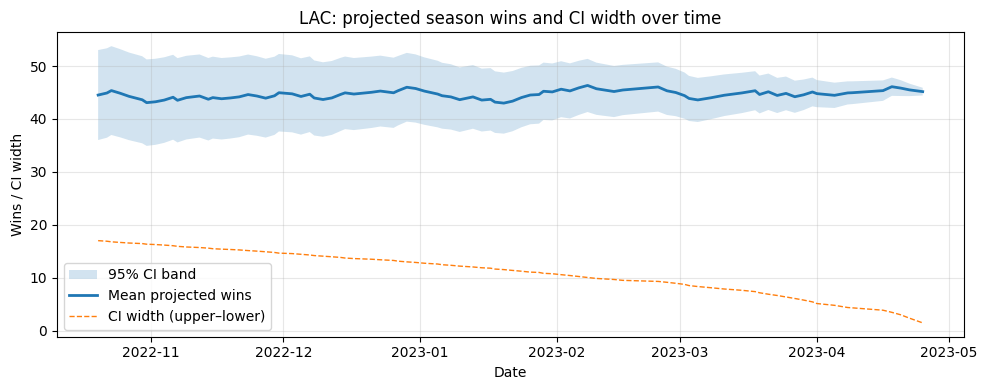

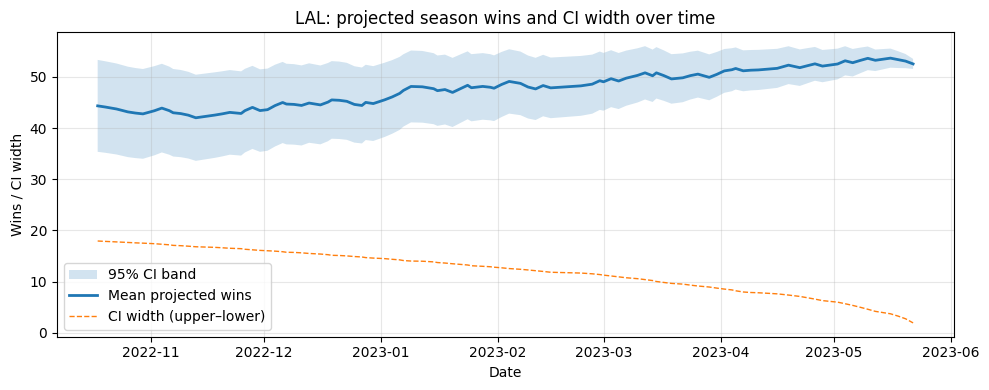

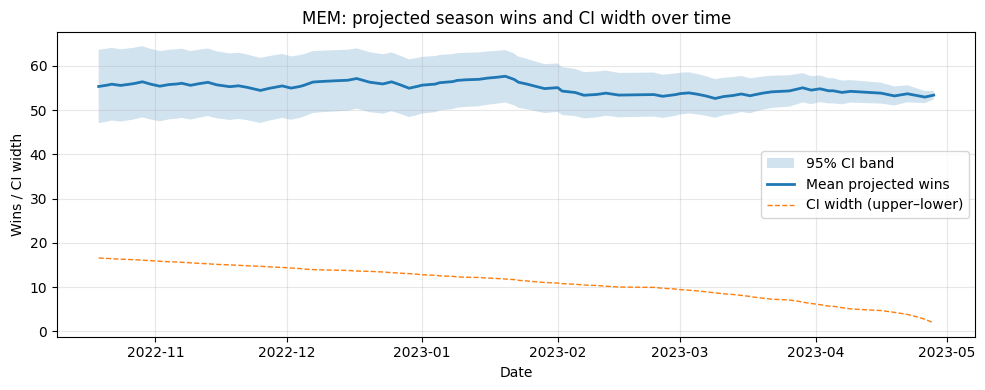

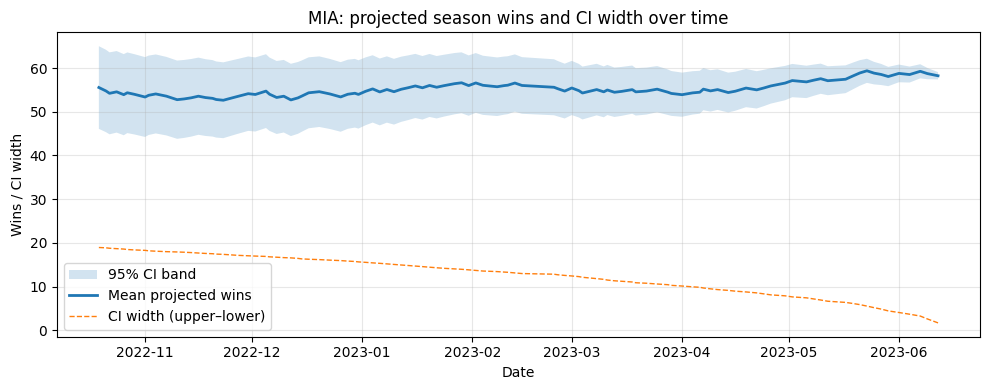

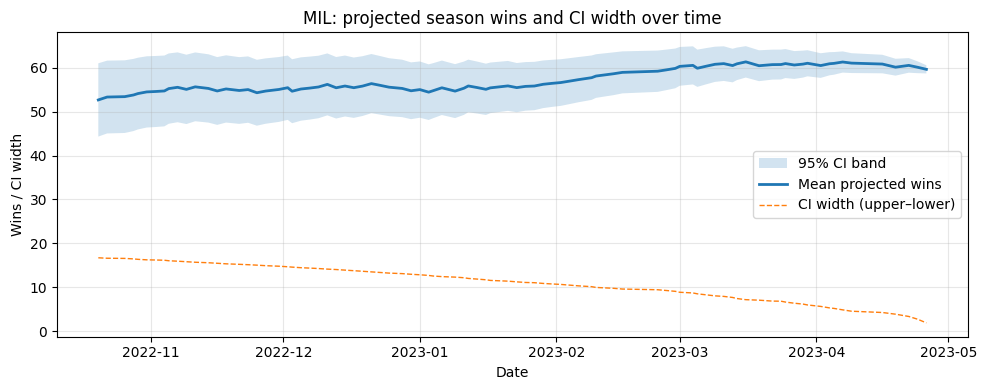

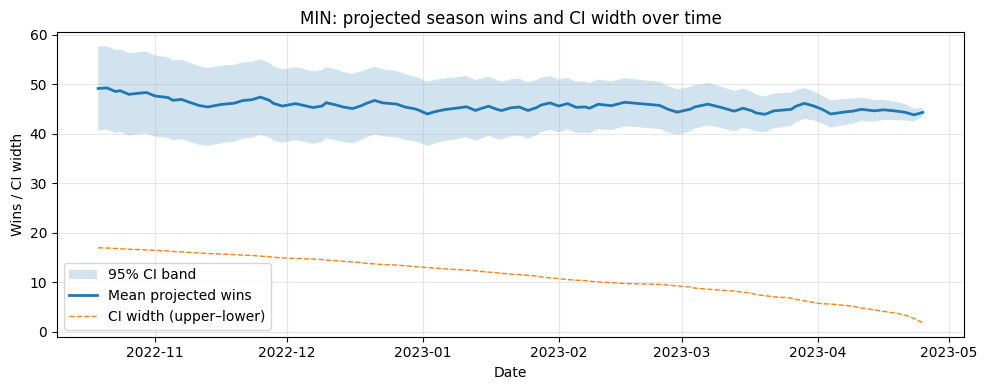

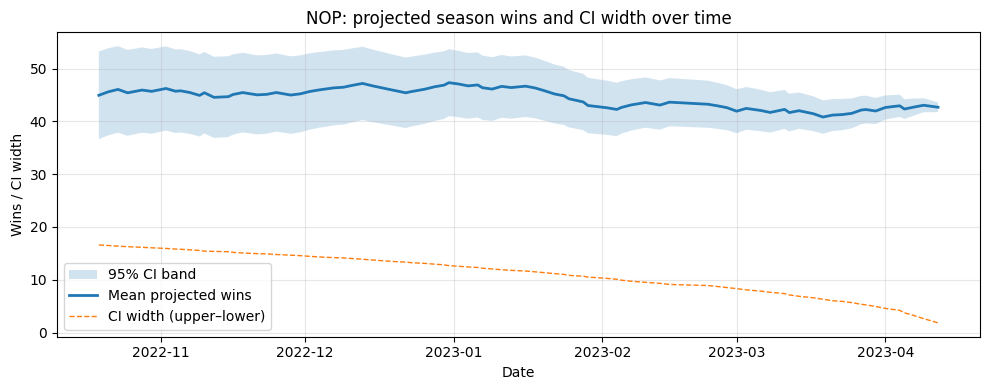

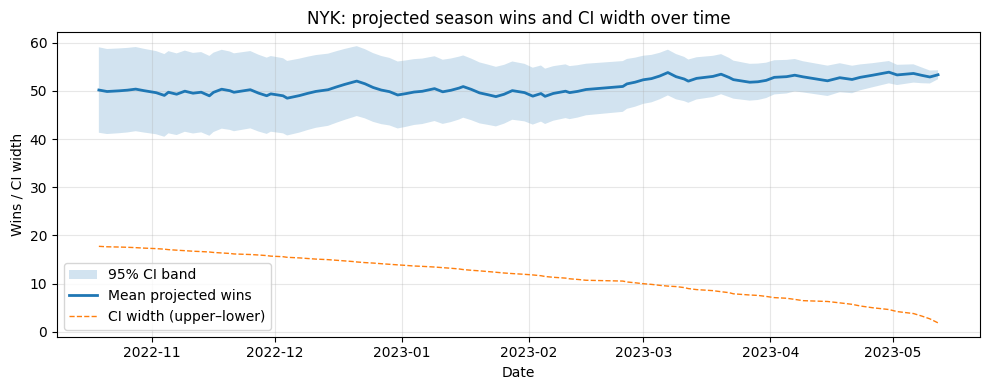

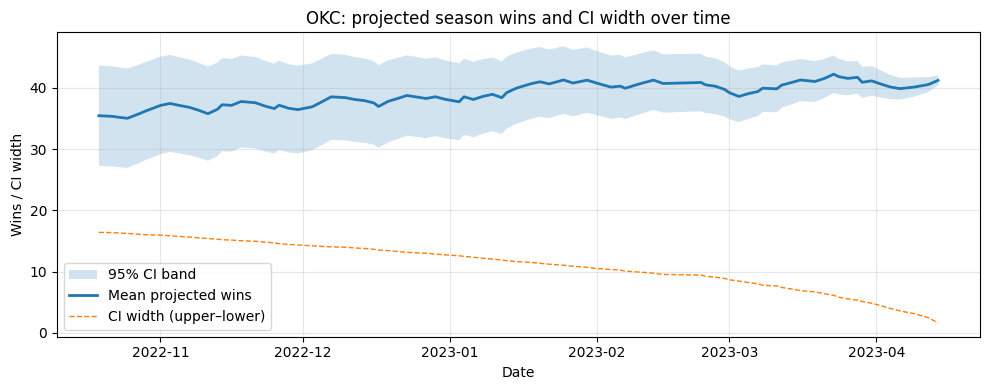

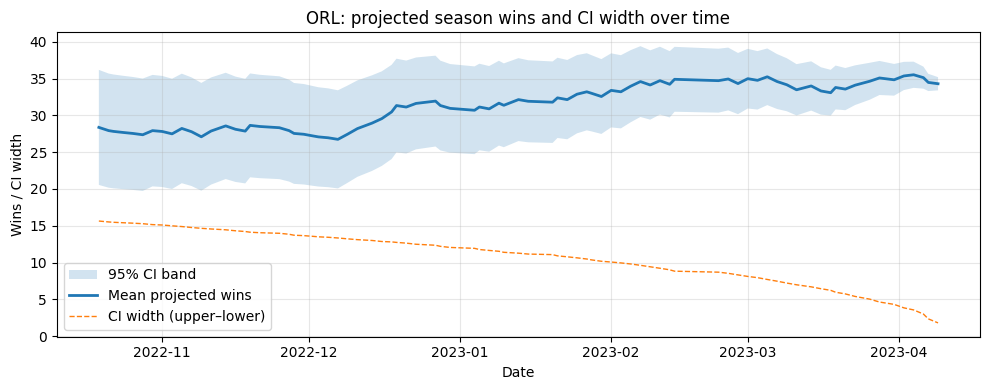

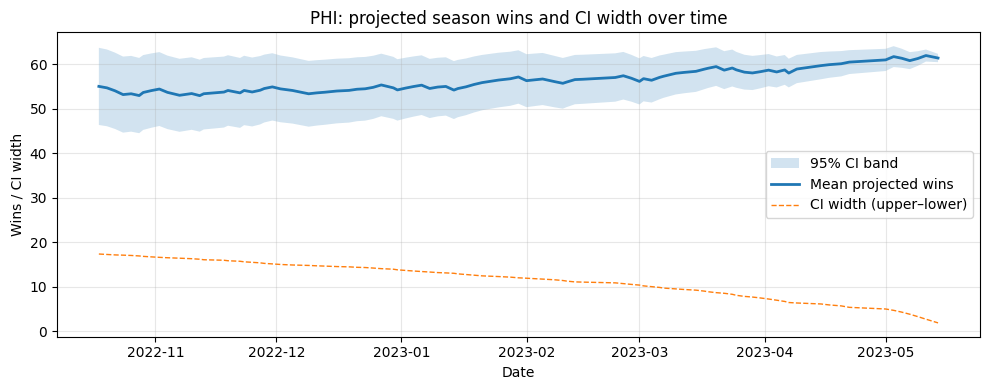

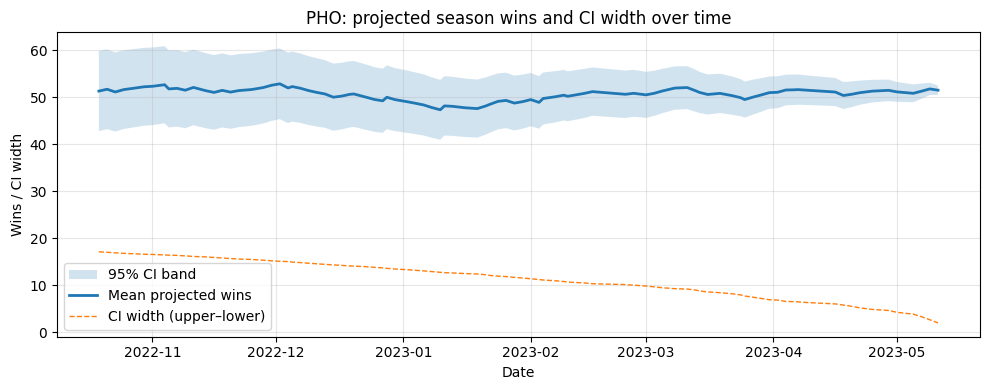

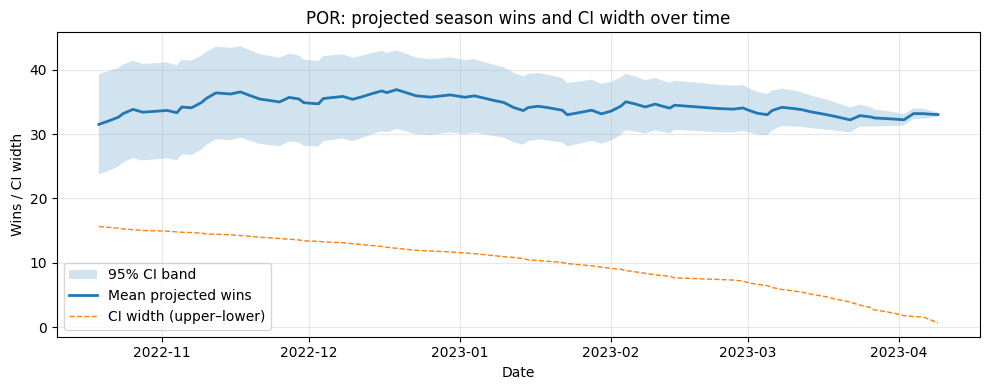

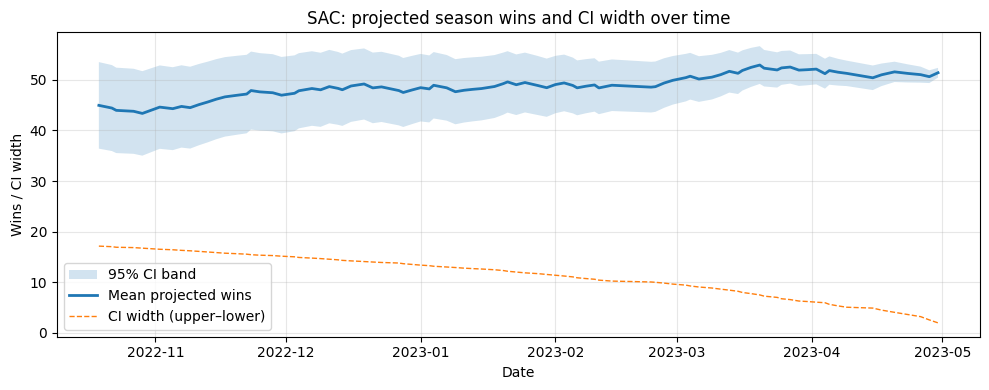

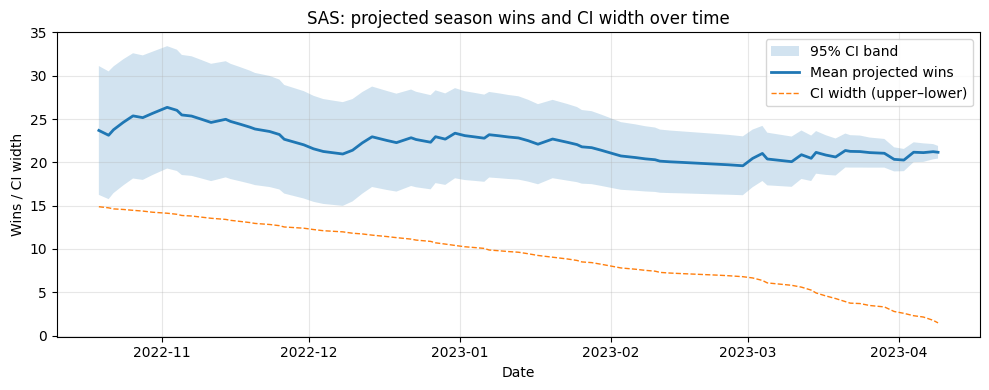

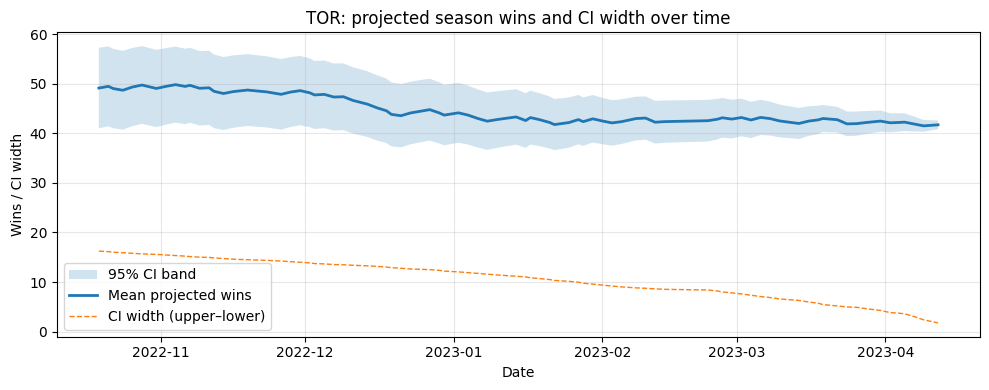

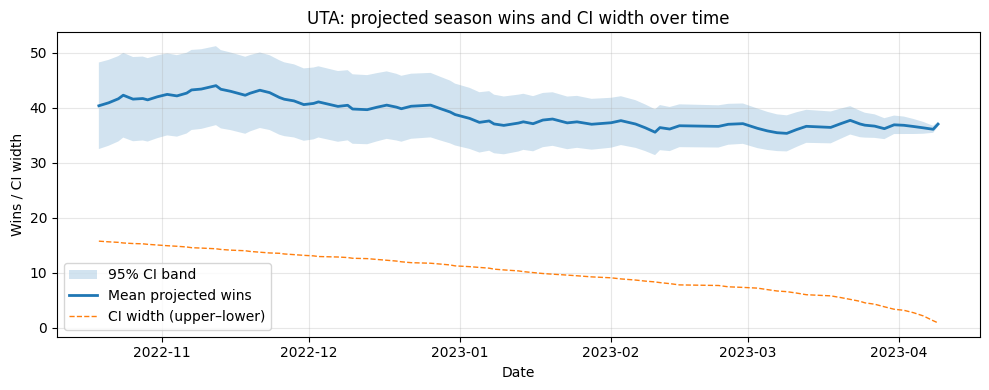

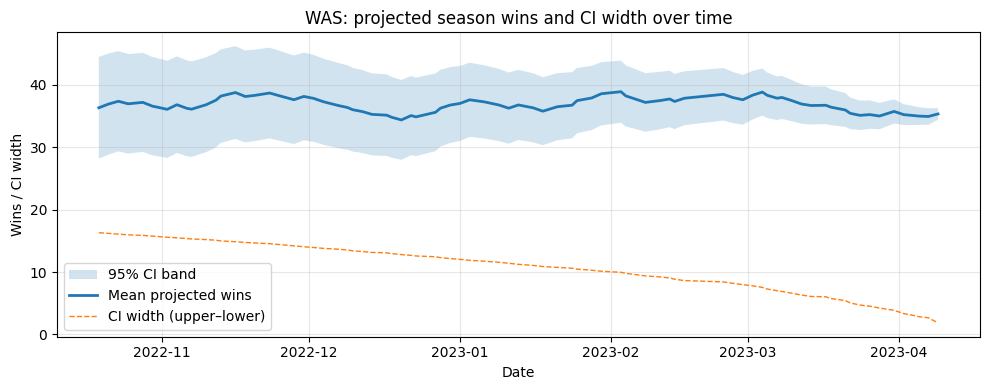

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load & flatten (same as before)
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])
records = []
for _, row in df.iterrows():
    records.append({'team': row['team1'], 'date': row['date'],
                    'prob': row['raptor_prob1'],
                    'actual': int(row['score1'] > row['score2'])})
    records.append({'team': row['team2'], 'date': row['date'],
                    'prob': row['raptor_prob2'],
                    'actual': int(row['score2'] > row['score1'])})
flat = pd.DataFrame(records)

# 2. Build the timeseries DataFrame, now including CI width
def build_ts(team):
    g = flat[flat['team']==team].sort_values('date')
    rows = []
    for d in g['date'].unique():
        past   = g[g['date'] < d]
        future = g[g['date'] >= d]
        actual_wins = past['actual'].sum()
        exp_wins    = future['prob'].sum()
        var_future  = (future['prob'] * (1 - future['prob'])).sum()
        sd_future   = np.sqrt(var_future)
        mean_total  = actual_wins + exp_wins
        lower = mean_total - 1.96*sd_future
        upper = mean_total + 1.96*sd_future
        # compute CI width
        ci_width = upper - lower
        rows.append({
            'date':     d,
            'mean':     mean_total,
            'lower':    lower,
            'upper':    upper,
            'ci_width': ci_width
        })
    return pd.DataFrame(rows)

# 3. Plot loop with CI width line
for team in sorted(flat['team'].unique()):
    ts = build_ts(team)
    plt.figure(figsize=(10, 4))
    # shaded CI band
    plt.fill_between(ts['date'], ts['lower'], ts['upper'], alpha=0.2,
                     label='95% CI band')
    # mean projection
    plt.plot(ts['date'], ts['mean'], lw=2, label='Mean projected wins')
    # CI width over time
    plt.plot(ts['date'], ts['ci_width'], lw=1, linestyle='--',
             label='CI width (upper–lower)')
    plt.title(f'{team}: projected season wins and CI width over time')
    plt.xlabel('Date')
    plt.ylabel('Wins / CI width')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
